In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
from torch.autograd import Variable

from generation.config import CHECKPOINT_DIR

In [8]:
# !git checkout -b "dashing-snowball-246" 1aa6891d16fe8ca13db7af041f022be29ccf6243
# !git checkout "dashing-snowball-246"
# !pip install -e ../..

Obtaining file:///datadrive/pafakanov/hse/hep_generative_models
  Attempting uninstall: generation
    Found existing installation: generation 0.6.2
    Uninstalling generation-0.6.2:
      Successfully uninstalled generation-0.6.2
  Running setup.py develop for generation


In [2]:
WANDB_ID = "16ywv7x4"

config = {
    "lr": 1e-5,
    "epochs_num": 2000,
    "batch_size": 64,
    "log_each": 1,
    "save_each": 2,
    "device": "cuda:1",
    "x_dim": 9,
    "z_dim": 3,
    "disc_coef": 5,
    "lambda": 5
}

In [3]:
from generation.dataset.amplitudes_dataset import AmplitudesDataset

dataset = AmplitudesDataset()

In [4]:
checkpoint_dir = os.path.join(CHECKPOINT_DIR, WANDB_ID)
checkpoint_paths = [os.path.join(checkpoint_dir, name) \
         for name in os.listdir(checkpoint_dir)]
checkpoint_paths.sort(key=os.path.getctime, reverse=True)
generator_checkpoint_paths = [path for path in checkpoint_paths \
                if os.path.basename(path).startswith("generator")]
discriminator_checkpoint_paths = [path for path in checkpoint_paths \
                if os.path.basename(path).startswith("discriminator")]

In [72]:
!pip install torchviz

     |████████████████████████████████| 41 kB 79 kB/s  eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3521 sha256=a648a88a6cec1023204ba5f12ad841dd02db52d6a0395390c43c9a3a9fda9c1c
  Stored in directory: /datadrive/pafakanov/.cache/pip/wheels/10/7b/c8/3af79ec02e294a832c01037bcb38302bbcee0bb020dcbbbd3e
Successfully built torchviz


In [73]:
from torchviz import make_dot


In [76]:
!pip install hiddenlayer

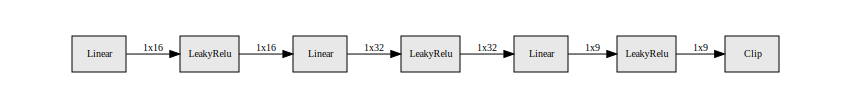

In [94]:
import hiddenlayer as hl

z = Variable(torch.rand(1, config['z_dim']))
g_graph = hl.build_graph(generator, z)
g_dot = g_graph.build_dot()
g_dot.attr("graph", rankdir="TD")
d_graph = hl.build_graph(discriminator,dataset[0].unsqueeze(0))
d_graph.theme = hl.graph.THEMES["blue"].copy()
d_dot = d_graph.build_dot()
d_dot.attr("graph", rankdir="TD")

g_graph

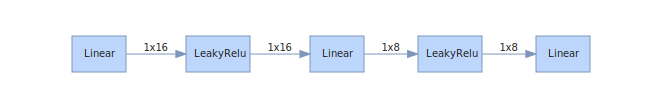

In [95]:
d_graph

In [5]:
from generation.nets.amplitudes import Generator, Discriminator


generator = Generator(config)
discriminator = Discriminator(config)
generator.load_state_dict(torch.load(generator_checkpoint_paths[0]))
discriminator.load_state_dict(torch.load(discriminator_checkpoint_paths[0]))

<All keys matched successfully>

In [16]:
NUM = 1000

def generate(generator, num=NUM):
    z = Variable(torch.rand(num, config['z_dim']))
    generated_noises = generator(z).detach().numpy()
    return generated_noises

In [17]:
generated_amplitudes = generate(generator)
idxs = np.random.choice(range(len(dataset)), NUM)
origin_amplitudes = dataset.amplitudes[idxs]

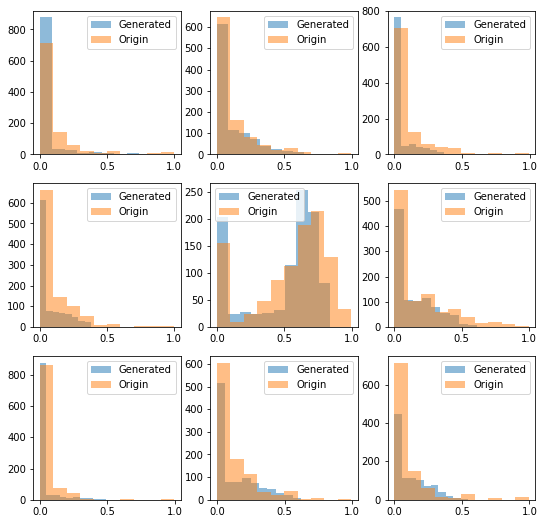

In [63]:
f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    ax[i // 3][i % 3].hist(generated_amplitudes[:, i], alpha=0.5)
    ax[i // 3][i % 3].hist(origin_amplitudes[:, i], alpha=0.5)


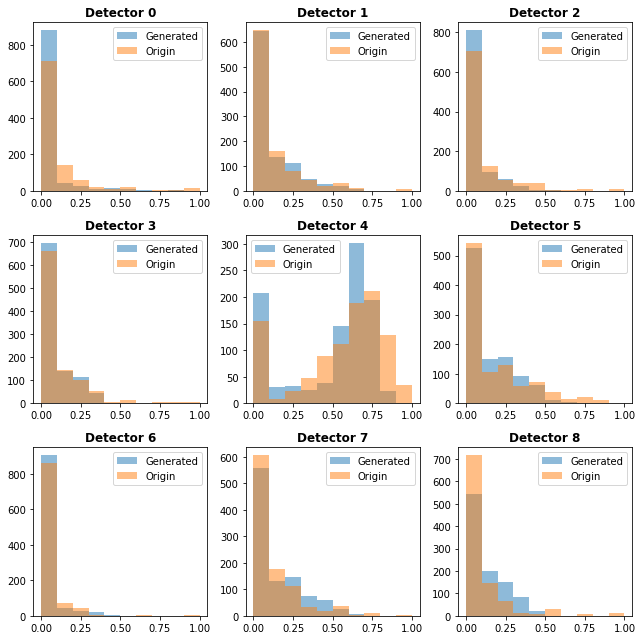

In [70]:
f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    ax[i // 3][i % 3].set_title(f"Detector {i}", weight='bold')
    ax[i // 3][i % 3].hist(generated_amplitudes[:, i], bins=np.arange(0, 1.01, 0.1), alpha=0.5)
    ax[i // 3][i % 3].hist(origin_amplitudes[:, i], bins=np.arange(0, 1.01, 0.1), alpha=0.5)
    ax[i // 3][i % 3].legend(['Generated', 'Origin'])
f.tight_layout()

100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


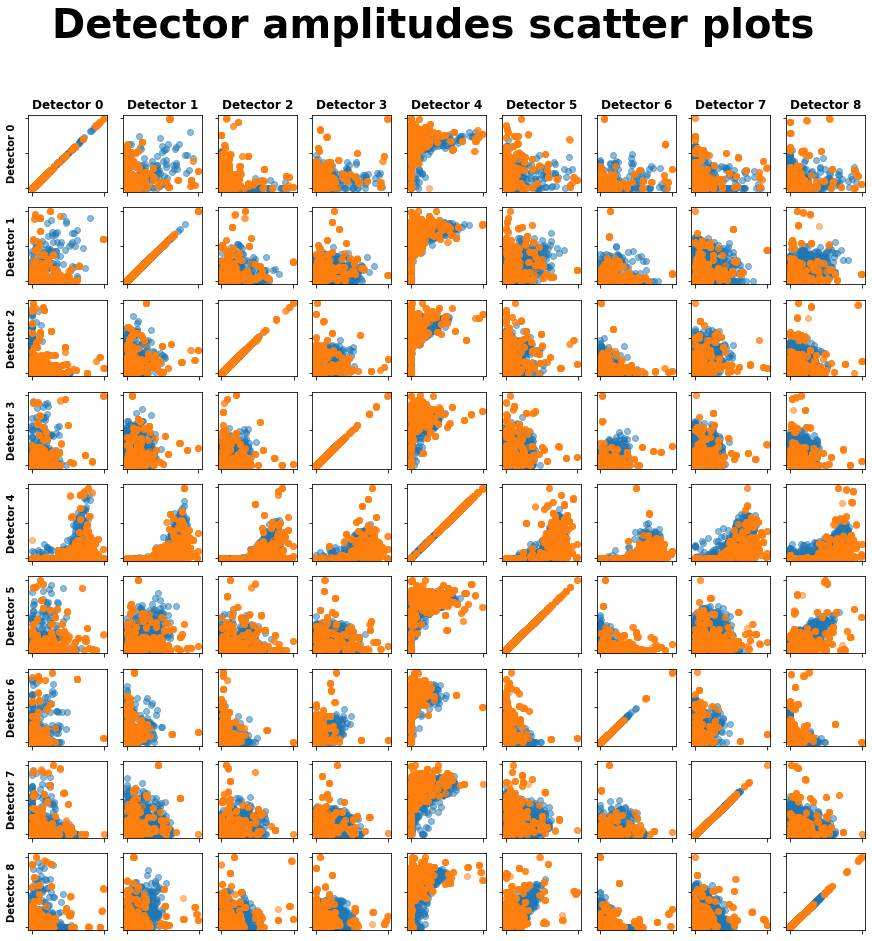

In [26]:
_DETECTORS_NUM = 9

def _plot_scatter(amplitudes, ax, detector1, detector2, alpha=1.0):
    amplitudes1 = amplitudes[:, detector1]
    amplitudes2 = amplitudes[:, detector2]
    ax.scatter(amplitudes1, amplitudes2, alpha=alpha)

def prepare_figure_axis():
    f, ax = plt.subplots(_DETECTORS_NUM, _DETECTORS_NUM, figsize=(15, 15))
    cols = ['Detector {}'.format(detector) for detector in range(_DETECTORS_NUM)]
    rows = ['Detector {}'.format(detector) for detector in range(_DETECTORS_NUM)]

    for _ax, col in zip(ax[0], cols):
        _ax.set_title(col, weight='bold')
    for _ax, row in zip(ax[:,0], rows):
        _ax.set_ylabel(row, weight='bold', rotation=90)
    f.suptitle("Detector amplitudes scatter plots", fontsize=40, weight='bold')
    return f, ax
    
f, ax = prepare_figure_axis()
for detector1 in tqdm.tqdm(range(_DETECTORS_NUM)):
    for detector2 in range(_DETECTORS_NUM):
        ax[detector1][detector2].set_xticklabels([])
        ax[detector1][detector2].set_yticklabels([])
        _plot_scatter(generated_amplitudes, ax[detector1][detector2], detector1, detector2, alpha=0.5)
        _plot_scatter(origin_amplitudes, ax[detector1][detector2], detector1, detector2, alpha=0.5)
plt.show()

In [50]:
def calculate_centre_mass(sample):
    coords = np.array([[-1, 1], [0, 1], [1, 1], \
          [-1, 0], [0, 0], [1, 0], \
          [-1, -1], [0, -1], [1, -1]])
    sample = np.repeat(sample[:, None], 2, axis=1)
    return np.sum(coords * sample, axis=0)

In [53]:
generated_centres = [calculate_centre_mass(sample) \
                     for sample in generated_amplitudes]
origin_centres = [calculate_centre_mass(sample) \
                     for sample in origin_amplitudes]

In [54]:
generated_centres = np.array(generated_centres)
origin_centres = np.array(origin_centres)

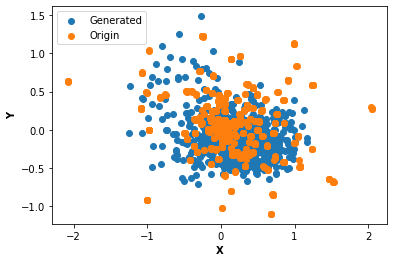

In [67]:
plt.scatter(generated_centres[:, 0], generated_centres[:, 1])
plt.scatter(origin_centres[:, 0], origin_centres[:, 1])
plt.xlabel("X", weight='bold')
plt.ylabel("Y", weight='bold')
plt.legend(['Generated', 'Origin'])
plt.show()